# Fashion-mnist using Keras


This notebook was adopted from:
https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline

## Loading The Dataset

In [166]:
from tensorflow.examples.tutorials.mnist import input_data

# CAUTION: Make sure to download the dataset first in
# data/fashion directory. Otherwise, tensorflow will
# download the traditional MNIST dataset
mnist = input_data.read_data_sets('data/fashion', one_hot=True)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


### Prepare the dataset

In [167]:
def TRAIN_SIZE(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = mnist.train.labels[:num,:]
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train

def TEST_SIZE(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = mnist.test.labels[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test

def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
        
def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()


In [168]:
x_train, y_train = TRAIN_SIZE(55000)
x_test, y_test = TEST_SIZE(10000)

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (55000, 784)
y_train Examples Loaded = (55000, 10)

Total Test Examples in Dataset = (10000, 784)
--------------------------------------------------
x_test Examples Loaded = (10000, 784)
y_test Examples Loaded = (10000, 10)


### Preview some images

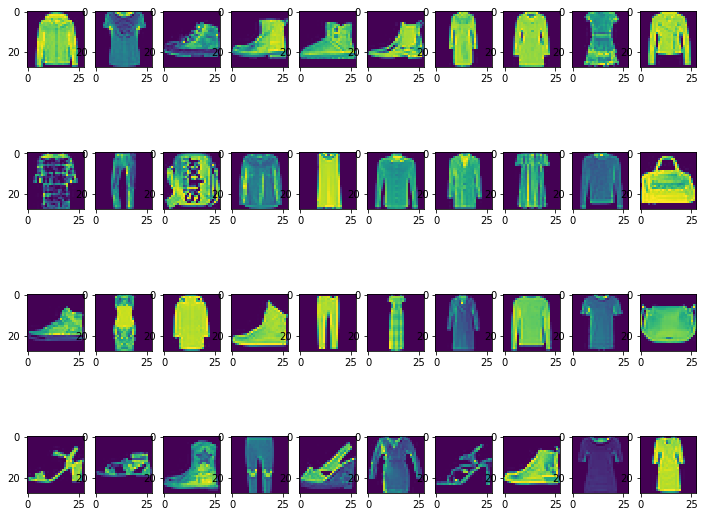

In [169]:
%matplotlib inline
plt.figure(figsize=(12, 10))
x, y = 10, 4

for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')

plt.show()

### Reshape To Match The Keras's Expectations

The dataset we loaded are in shape x_train: (55000, 784), y_train: (10000, 784), which means images are loaded in vectors. Vectors are needed for models build using Tensorflow (Yup, we loaded the data formatted for Tensorflow using Tensorflow :)) But Keras expect them as matrix format (num_of_samples, width, height, channels). So, we will reshape the datasets expected as by Keras. 

In [170]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

### Import necessary modules

In [171]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


### Define necessary training parameters

In [172]:
batch_size = 64
num_classes = len(classes)
epochs = 20
input_shape = (28, 28, 1) # (width, height, channels)

In [173]:
# convert class vectors to binary class matrices One Hot Encoding
# We don't need it. Our class matrices are already one hot encoded
# y_train = keras.utils.to_categorical(y_train, num_classes)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [174]:
# Lets have a look at training and testing datasets
# print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, num_classes)

**Linear Model**

In [175]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [176]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
__________

In [177]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                        epochs=epochs, 
                        validation_data=(X_test, y_test), 
                        verbose=1, 
                        steps_per_epoch=100, 
                        callbacks=[learning_rate_reduction])

Epoch 1/20
100/100 [==============================] - 17s 175ms/step - loss: 1.2539 - acc: 0.5522 - val_loss: 0.9019 - val_acc: 0.6757
Epoch 2/20
100/100 [==============================] - 20s 198ms/step - loss: 0.8458 - acc: 0.6839 - val_loss: 0.7432 - val_acc: 0.7514
Epoch 3/20
100/100 [==============================] - 17s 166ms/step - loss: 0.7458 - acc: 0.7164 - val_loss: 0.6074 - val_acc: 0.7749
Epoch 4/20
100/100 [==============================] - 17s 172ms/step - loss: 0.6978 - acc: 0.7311 - val_loss: 0.6511 - val_acc: 0.7722
Epoch 5/20
100/100 [==============================] - 17s 175ms/step - loss: 0.6339 - acc: 0.7536 - val_loss: 0.5741 - val_acc: 0.7869
Epoch 6/20
100/100 [==============================] - 17s 174ms/step - loss: 0.6061 - acc: 0.7741 - val_loss: 0.5950 - val_acc: 0.7684
Epoch 7/20
100/100 [==============================] - 17s 169ms/step - loss: 0.5836 - acc: 0.7805 - val_loss: 0.4782 - val_acc: 0.8205
Epoch 8/20
100/100 [==============================] - 1

## Basic Simple Plot And Evaluation

In [180]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.328576, final accuracy: 0.878600


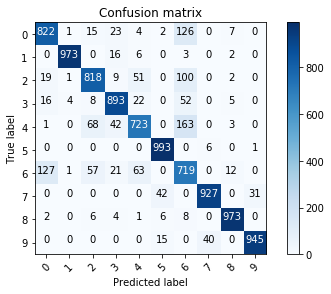

In [181]:
# Look at confusion matrix 
# Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


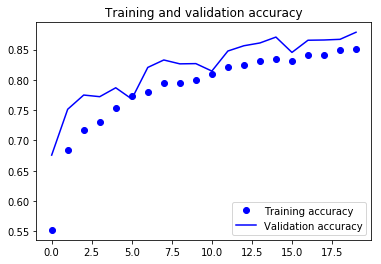

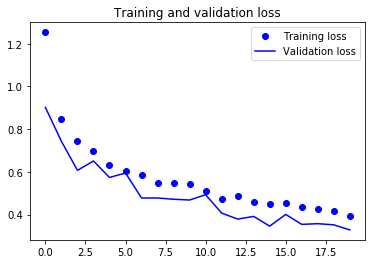

In [182]:
print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

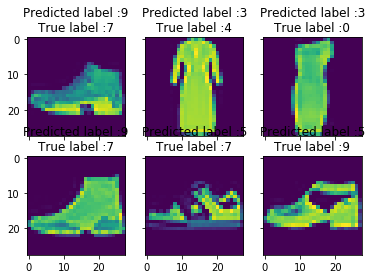

In [183]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

## Activations Look Like What?

It looks like diversity of the similar patterns present on multiple classes effect the performance of the classifier although CNN is a robust architechture.

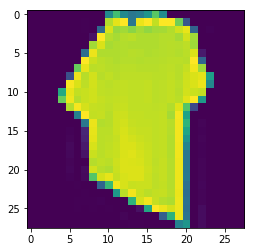

In [187]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28, 28), cmap='viridis', interpolation='none')

**Let's see the activation of the 2nd channel of the first layer:**

**Had taken help from the keras [docs](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer), this [answer](https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer) on  StackOverFlow**

/Users/moshfiqur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


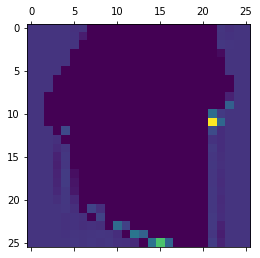

In [188]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

**Let's plot the activations of the other conv layers as well.**

In [189]:
model.layers[:-1]# Droping The Last Dense Layer

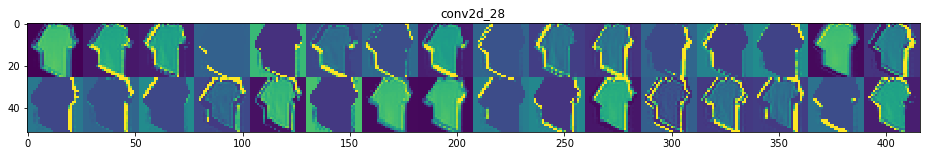

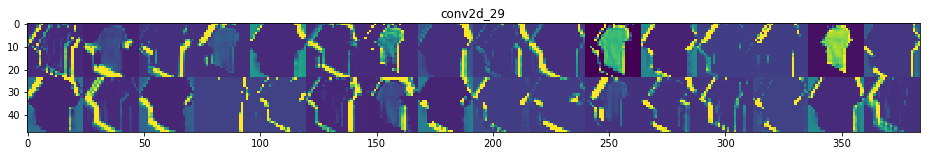

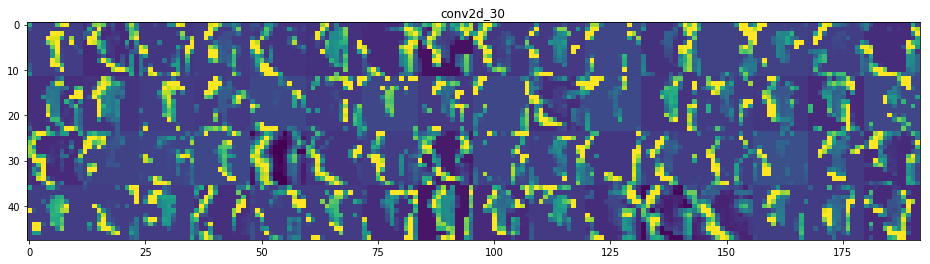

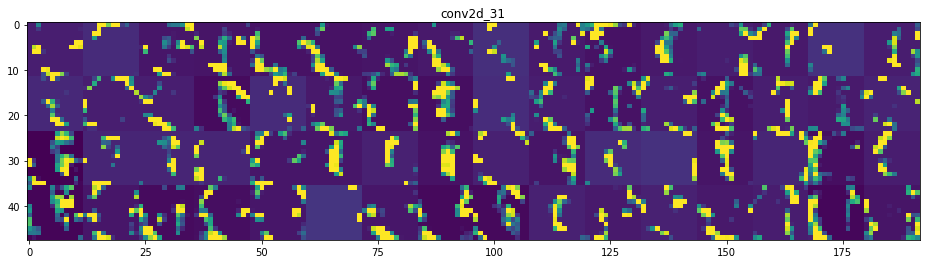

In [190]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

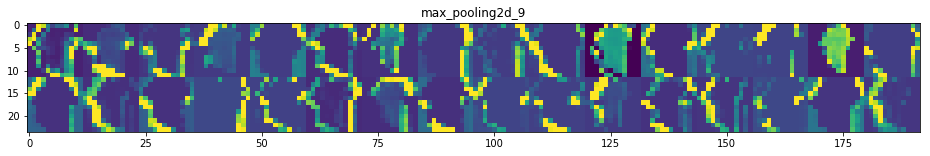

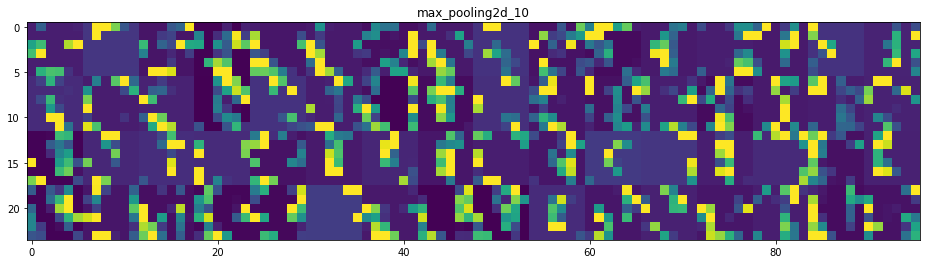

In [191]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

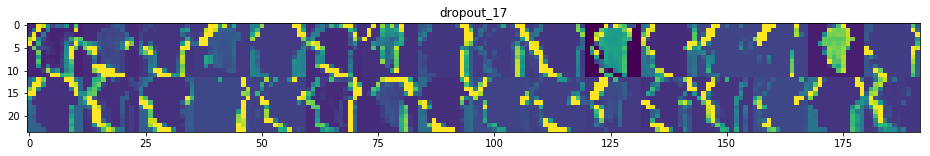

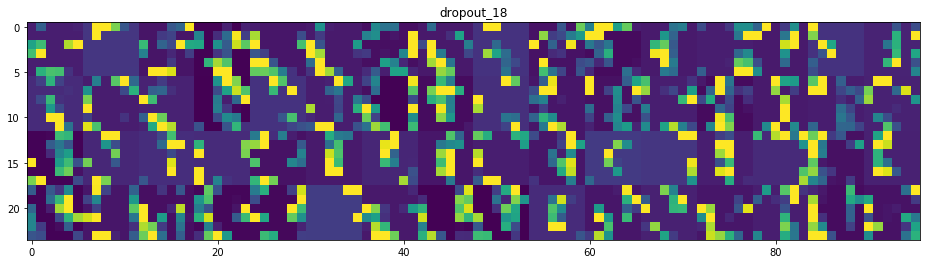

In [192]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('drop'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Classifcation Report

In [193]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#get the indices to be plotted
# y_true = test.iloc[:, 0]
# correct = np.nonzero(predicted_classes==y_true)[0]
# incorrect = np.nonzero(predicted_classes!=y_true)[0]
predicted_classes[0]

9

In [195]:
# from sklearn.metrics import classification_report
# target_names = ["Class {}".format(i) for i in range(num_classes)]
# print(classification_report(y_true, predicted_classes, target_names=target_names))

In [196]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predicted_classes)+1)),
                         "Label": predicted_classes})
submissions.to_csv("asd.csv", index=False, header=True)

In [197]:
model.save('my_model_1.h5')
json_string = model.to_json()

In [198]:
def display_compare(num):
    # THIS WILL LOAD ONE TRAINING EXAMPLE
    x_test = mnist.test.images[num,:]
    y_test = mnist.test.labels[num,:]
    
    x_test = x_test.reshape(1, 28, 28,1)
    
    # THIS GETS OUR LABEL AS A INTEGER
    label = classes[y_test.argmax()]
    
    # THIS GETS OUR PREDICATION AS A INTEGER
    prediction = model.predict_classes(x_test)[0]
    # prediction = sess.run(y, feed_dict={x: x_train})
    # print(prediction)
    # prediction = prediction.argmax()
    prediction = classes[prediction]
    
    plt.title('Prediction: %s Label: %s' % (prediction, label))
    plt.imshow(x_test.reshape([28,28]), cmap=plt.get_cmap('gray_r'))
    plt.show()
    

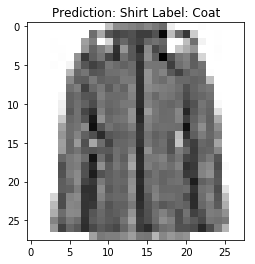

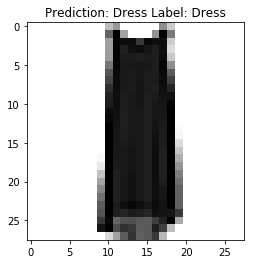

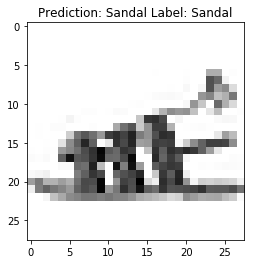

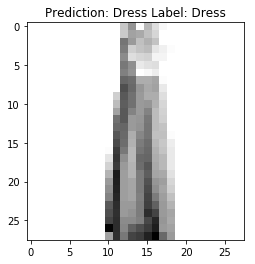

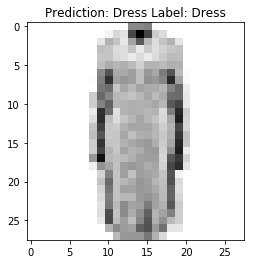

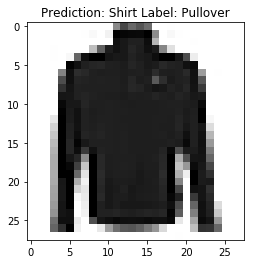

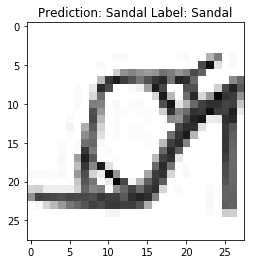

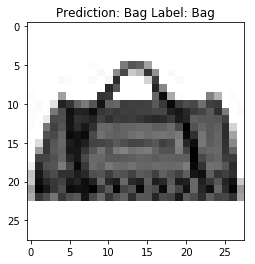

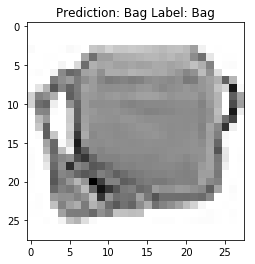

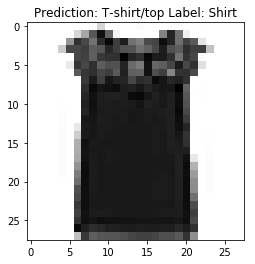

In [199]:
for i in range(0, 10):
    display_compare(ran.randint(0, 10000))


working on  images/test/10752570.jpg


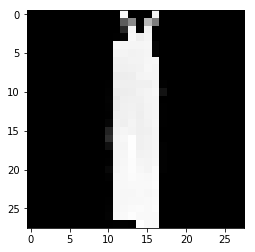

1


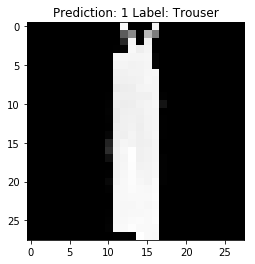

working on  images/test/61X9KGJ4I+L._UX385_.jpg


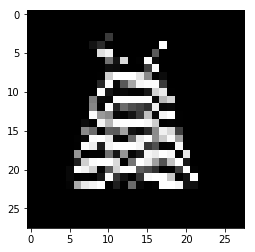

8


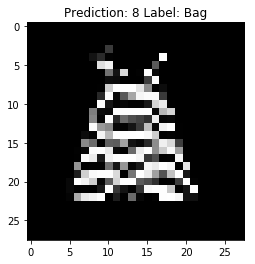

working on  images/test/girl_boot_1.jpg


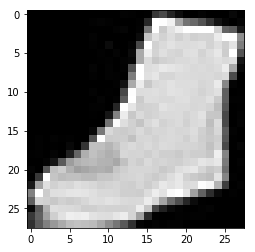

9


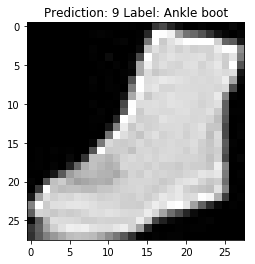

working on  images/test/girl_tshirt_1.jpg


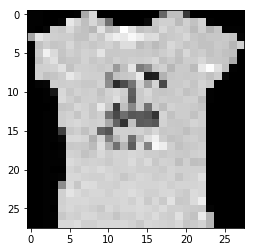

0


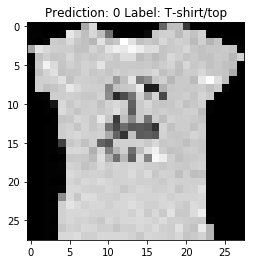

working on  images/test/men_shirt_1.jpg


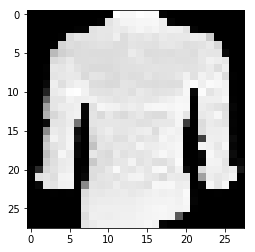

0


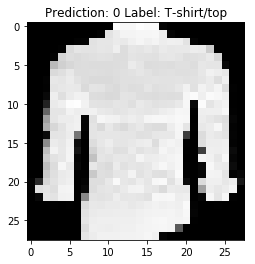

working on  images/test/Shybobbi-New-Girls-Dress-Red-Dot-Collar-Party-Birthday-Lovely-Baby-Child-Clothes-100-Cotton.jpg


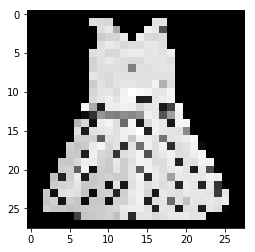

3


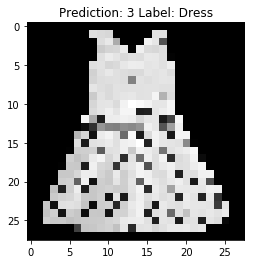

working on  images/test/ss-men-s-jeans-1.jpg


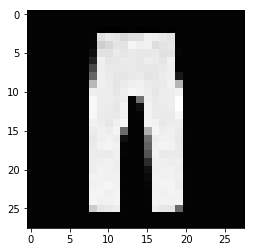

1


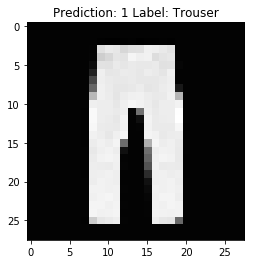

working on  images/test/ss-men-s-sportwear-1.jpg


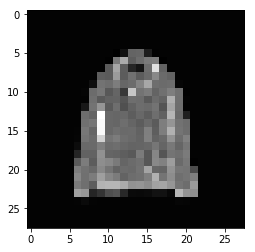

4


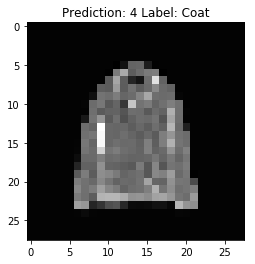

In [202]:
import os
import glob
import cv2

img_size = 28

path = os.path.join('images', 'test', '*g')
files = glob.glob(path)
for img_file in files:
    print('working on ', img_file)
    test_im = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    # test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
    # test_im = cv2.resize(test_im, (img_size, img_size))
    
    # invert grayscale
    test_im = 255 - cv2.resize(test_im, (img_size, img_size), cv2.INTER_LINEAR)
    
    plt.imshow(test_im, cmap=plt.get_cmap('Greys_r'))
    plt.show()
    # test_im = test_im.reshape(1, img_size, img_size, num_channels)
    # test_im = test_im.flatten().reshape(1, 784)
    test_im = test_im.reshape(1, 28, 28,1)
    # print(test_im.shape)
    # cv2.imshow('image', test_im)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # print(test_im.shape)

    # THIS GETS OUR LABEL AS A INTEGER
    # label = classes[y_train.argmax()]
    # label = 'dummy'
    
    # THIS GETS OUR PREDICATION AS A INTEGER
    # prediction = sess.run(y, feed_dict={x: test_im})
    prediction = model.predict_classes(test_im)[0]
    print(prediction)
    # prediction = prediction.argmax()
    
    plt.title('Prediction: %d Label: %s' % (prediction, classes[prediction]))
    plt.imshow(test_im.reshape([28,28]), cmap=plt.get_cmap('Greys_r'))
    plt.show()
